In [1]:
import argparse


def create_argparser():
    parser = argparse.ArgumentParser()

    # Run parameters
    parser.add_argument('--epochs', type=int, default=1000,
                        help='number of epochs')
    parser.add_argument('--batch_size', type=int, default=128,
                        help='Batch size. Does not scale with number of gpus.')
    parser.add_argument('--lr', type=float, default=5e-4,
                        help='learning rate')
    parser.add_argument('--weight_decay', type=float, default=1e-8,
                        help='weight decay')
    parser.add_argument('--print', type=int, default=100,
                        help='print interval')
    parser.add_argument('--log', type=bool, default=False,
                        help='logging flag')
    parser.add_argument('--num_workers', type=int, default=4,
                        help='Num workers in dataloader')
    parser.add_argument('--save_dir', type=str, default="saved models",
                        help='Directory in which to save models')

    # Data parameters
    parser.add_argument('--dataset', type=str, default="qm9",
                        help='Data set')
    parser.add_argument('--root', type=str, default="datasets",
                        help='Data set location')
    parser.add_argument('--download', type=bool, default=False,
                        help='Download flag')

    # QM9 parameters
    parser.add_argument('--target', type=str, default="alpha",
                        help='Target value, also used for gravity dataset [pos, force]')
    parser.add_argument('--radius', type=float, default=2,
                        help='Radius (Angstrom) between which atoms to add links.')
    parser.add_argument('--feature_type', type=str, default="one_hot",
                        help='Type of input feature: one-hot, or Cormorants charge thingy')

    # Nbody parameters:
    parser.add_argument('--nbody_name', type=str, default="nbody_small",
                        help='Name of nbody data [nbody, nbody_small]')
    parser.add_argument('--max_samples', type=int, default=3000,
                        help='Maximum number of samples in nbody dataset')
    parser.add_argument('--time_exp', type=bool, default=False,
                        help='Flag for timing experiment')
    parser.add_argument('--test_interval', type=int, default=5,
                        help='Test every test_interval epochs')
    parser.add_argument('--n_nodes', type=int, default=5,
                        help='How many nodes are in the graph.')

    # Gravity parameters:
    parser.add_argument('--neighbours', type=int, default=6,
                        help='Number of connected nearest neighbours')

    # Model parameters
    parser.add_argument('--model', type=str, default="segnn",
                        help='Model name')
    parser.add_argument('--hidden_features', type=int, default=128,
                        help='max degree of hidden rep')
    parser.add_argument('--lmax_h', type=int, default=2,
                        help='max degree of hidden rep')
    parser.add_argument('--lmax_attr', type=int, default=3,
                        help='max degree of geometric attribute embedding')
    parser.add_argument('--subspace_type', type=str, default="weightbalanced",
                        help='How to divide spherical harmonic subspaces')
    parser.add_argument('--layers', type=int, default=7,
                        help='Number of message passing layers')
    parser.add_argument('--norm', type=str, default="instance",
                        help='Normalisation type [instance, batch]')
    parser.add_argument('--pool', type=str, default="avg",
                        help='Pooling type type [avg, sum]')
    parser.add_argument('--conv_type', type=str, default="linear",
                        help='Linear or non-linear aggregation of local information in SEConv')

    # Parallel computing stuff
    parser.add_argument('-g', '--gpus', default=0, type=int,
                        help='number of gpus to use (assumes all are on one node)')

    return parser

In [2]:
import glob
import os
import numpy as np
import torch
import sys
from datasets.nbody.dataset_gravity import GravityDataset

torch.manual_seed(42)

print(sys.executable)

import utils.nbody_utils as ut

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

run = os.path.join("segnn_runs", "2024-03-11 16-42_gravity_segnn")

models = glob.glob(run + "/" + '*.pth')
if len(models) > 1:
    print("MORE MODELS FOUND IN THE DIR, LOADING THE FIRST:", models[0])

model = torch.load(models[0], map_location=device)

sys.argv = [
    'main.py', '--dataset=gravity', '--epochs=5', '--max_samples=3000',
    '--model=segnn', '--lmax_h=1', '--lmax_attr=1', '--layers=4',
    '--hidden_features=64', '--subspace_type=weightbalanced', '--norm=none',
    '--batch_size=100', '--gpu=1', '--weight_decay=1e-12', '--target=pos'
]
parser = create_argparser()

args = parser.parse_args()

dataset_train = GravityDataset(partition='train', dataset_name=args.nbody_name,
                               max_samples=args.max_samples, neighbours=args.neighbours, target=args.target)

C:\Users\MartinKaras(AI)\.conda\envs\n_body_approx_3_10\python.exe


# Batch simulation

In [3]:
from torch_geometric.data import Data
from torch_geometric.nn import knn_graph
from datasets.nbody.train_gravity import O3Transform

transform = O3Transform(args.lmax_attr)

simulation_index = 0

loc, vel, force, mass = dataset_train.data

output_dims = 3
batch_size = 50
n_nodes = 5
t_delta = 2

loc = torch.from_numpy(loc[simulation_index]).view(-1, output_dims)
vel = torch.from_numpy(vel[simulation_index]).view(-1, output_dims)
force = torch.from_numpy(force[simulation_index]).view(-1, output_dims)
mass = mass[simulation_index].repeat(batch_size, 1)
data = [loc, vel, force, mass]

if args.target == 'pos':
    y = loc
else:
    y = force

data = [d.to(device) for d in data]
loc, vel, force, mass = data

graph = Data(pos=loc, vel=vel, force=force, mass=mass, y=y)
batch = torch.arange(0, batch_size)
graph.batch = batch.repeat_interleave(n_nodes).long()
graph.edge_index = knn_graph(loc, args.neighbours, graph.batch)

graph = transform(graph)  # Add O3 attributes
graph = graph.to(device)
pred = model(graph)

C:\Users\MartinKaras(AI)\.conda\envs\n_body_approx_3_10\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)


# Stepwise simulation

In [4]:
# import torch
# from torch_geometric.data import Data
# from torch_geometric.nn import knn_graph
# from datasets.nbody.train_gravity import O3Transform
# 
# transform = O3Transform(args.lmax_attr)
# 
# simulation_index = 0
# 
# loc, vel, force, mass = dataset_train.data
# 
# output_dims = 3
# n_nodes = 5
# t_delta = 2
# 
# # Assuming simulation_steps is defined or calculated from your dataset
# simulation_steps = len(loc[simulation_index])  # Or however you determine the number of steps
# 
# for step in range(simulation_steps):
#     loc_step = torch.from_numpy(loc[simulation_index][step]).view(-1, output_dims).to(device)
#     vel_step = torch.from_numpy(vel[simulation_index][step]).view(-1, output_dims).to(device)
#     force_step = torch.from_numpy(force[simulation_index][step]).view(-1, output_dims).to(device)
#     mass_step = torch.tensor(mass[simulation_index], dtype=torch.float).repeat(n_nodes, 1).to(device)
# 
#     if args.target == 'pos':
#         y_step = loc_step
#     else:
#         y_step = force_step
# 
#     graph = Data(pos=loc_step, vel=vel_step, force=force_step, mass=mass_step, y=y_step)
#     # Since we're dealing with single steps, no need to batch
#     graph.edge_index = knn_graph(loc_step, args.neighbours)
# 
#     graph = transform(graph)  # Add O3 attributes
#     graph = graph.to(device)
#     pred = model(graph)
# 
#     # Process prediction here or store for later analysis


# Plot the whole simulation

In [6]:
import utils.nbody_utils as ut
%matplotlib qt

particle_index = 4
boxSize = 5

predicted_data = pred.view(batch_size, n_nodes, output_dims).detach().cpu().numpy()
loc_orig = loc.view(batch_size, n_nodes, output_dims)

targets = []
for i in range(0, batch_size - t_delta):
    targets.append(loc_orig[i + t_delta, :, :])

targets_np = np.array(targets)
hmm = loc_orig

ut.plot_trajectory(targets_np[: (batch_size - t_delta), ...], predicted_data, particle_index=particle_index, loggers=[],
                   epoch=1,
                   dims=output_dims)

# Interactive plot of the simulation

In [9]:
import importlib

importlib.reload(ut)

sim_steps = batch_size - t_delta
ut.interactive_trajectory_plot_all_particles_3d(targets_np[0:sim_steps, ...], predicted_data[0:sim_steps, ...],
                                                particle_index,
                                                boxSize=boxSize, dims=output_dims, offline_plot=False, loggers=[],
                                                video_tag=f"One step prediction of a particle {particle_index}")

# Pre istotu overenie, ci pri inferenci dosiahnem rovnaky result ako pocas treningu
...spoiler alert, ano dostanem

In [7]:
dataset_train = GravityDataset(partition='train', dataset_name=args.nbody_name,
                               max_samples=args.max_samples, neighbours=args.neighbours, target=args.target)
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=args.batch_size, shuffle=True, drop_last=True)

dataset_val = GravityDataset(partition='val', dataset_name=args.nbody_name,
                             neighbours=args.neighbours, target=args.target)
loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=args.batch_size, shuffle=False, drop_last=False)

dataset_test = GravityDataset(partition='test', dataset_name=args.nbody_name,
                              neighbours=args.neighbours, target=args.target)
loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=args.batch_size, shuffle=False, drop_last=False)

from torch import nn

model.eval()
criterion = nn.MSELoss()
#criterion = nn.L1Loss()


loaders = {"train": loader_train,
           # "valid": loader_val,
           # "test": loader_test,
           }

batch_size = args.batch_size

tartets_across_sims = []
predicted_data_across_sims = []
for name, loader in loaders.items():
    res = {'dataset': "test", 'loss': 0, 'counter': 0}
    for batch_idx, data in enumerate(loader):
        batch_size, n_nodes, _ = data[0].size()
        data = [d.to(device) for d in data]
        data = [d.view(-1, d.size(2)) for d in data]
        loc, vel, force, mass, y = data

        graph = Data(pos=loc, vel=vel, force=force, mass=mass, y=y)
        batch = torch.arange(0, batch_size)
        graph.batch = batch.repeat_interleave(n_nodes).long()
        graph.edge_index = knn_graph(loc, args.neighbours, graph.batch)

        graph = transform(graph)  # Add O3 attributes
        graph = graph.to(device)

        tartets_across_sims.append(graph.y)
        pred = model(graph)
        predicted_data_across_sims.append(pred)

        loss = criterion(pred, graph.y)

        #print("loss:", loss.item() * batch_size)
        res['loss'] += loss.item() * batch_size
        res['counter'] += batch_size

        #break

    print('%s epoch avg loss: %.5f' % (loader.dataset.partition, res['loss'] / res['counter']))

    print(res['loss'] / res['counter'])




train epoch avg loss: 0.00782
0.007820523008358886


# Interaktivny plot 

In [18]:
import importlib

importlib.reload(ut)

batch_index = 0
bodies = 5
dims = 3

target_batch = tartets_across_sims[batch_index].view(args.batch_size, bodies, dims).detach().cpu().numpy()
predicted_batch = predicted_data_across_sims[batch_index].view(args.batch_size, bodies, dims).detach().cpu().numpy()

sim_steps = batch_size - t_delta
ut.interactive_trajectory_plot_all_particles_3d(target_batch[0:sim_steps, ...], predicted_batch[0:sim_steps, ...],
                                                particle_index,
                                                boxSize=boxSize, dims=output_dims, offline_plot=False, loggers=[],
                                                video_tag=f"One step prediction of a particle {particle_index}", trace_length=1)

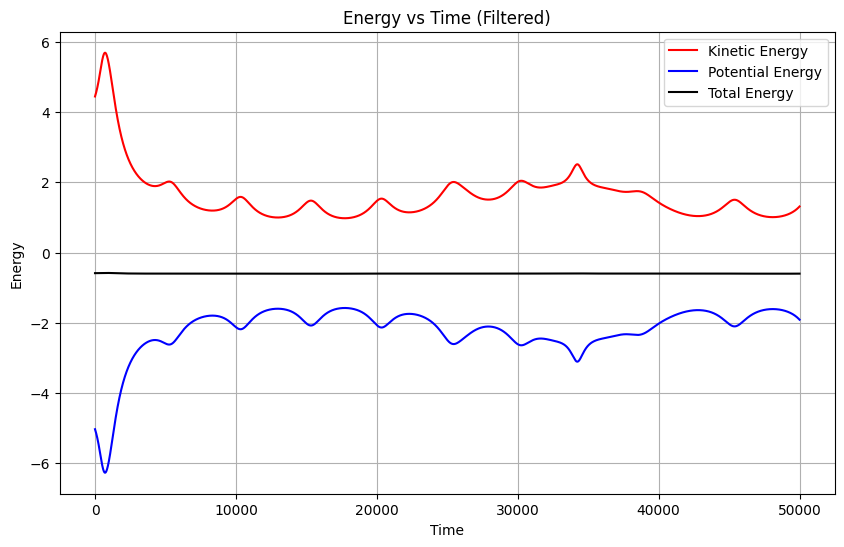

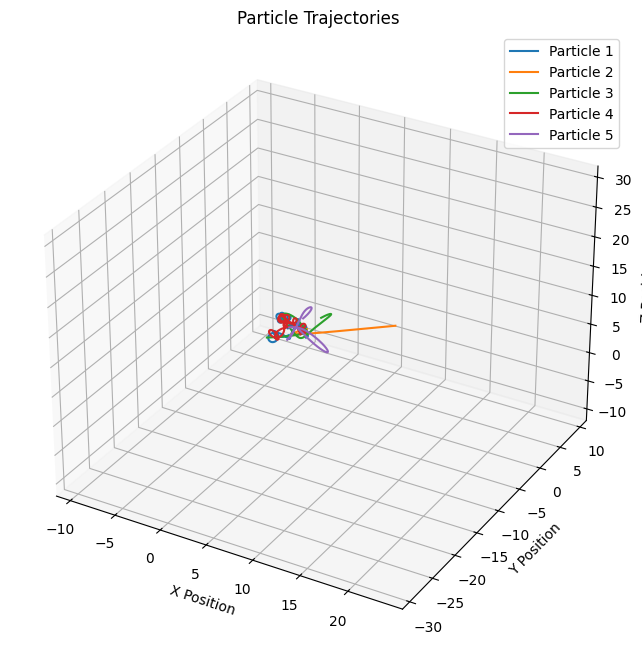

In [15]:
import datasets.nbody.dataset.synthetic_sim as synthetic_sim

import importlib

importlib.reload(synthetic_sim)


np.random.seed(43)

sim = synthetic_sim.GravitySim(n_balls=5, loc_std=1)

loc, vel, force, mass = sim.sample_trajectory(T=50000, sample_freq=1)

offset = 4000
N_frames = loc.shape[0] - offset
N_particles = loc.shape[-2]

sim.plot_energies(loc, vel, mass)

sim.plot_trajectory_static(loc)

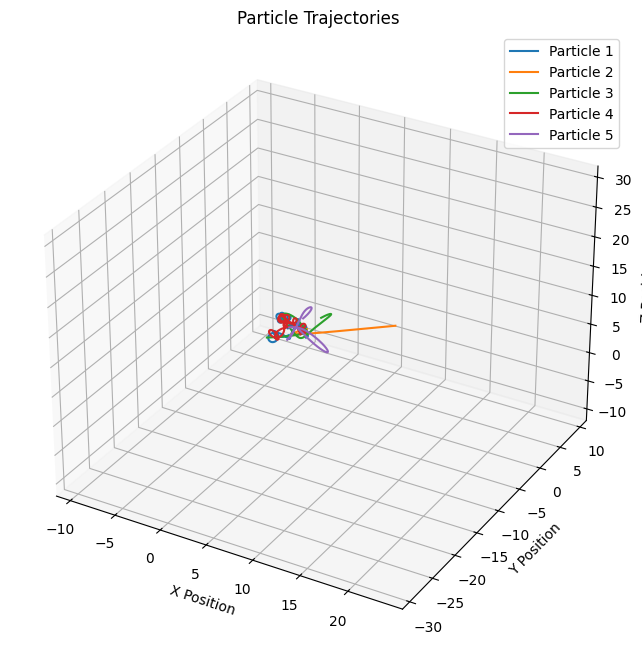

In [16]:
sim.plot_trajectory_static(loc)